In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import time



In [2]:
def plot(arr_x, arr_y):
    plt.figure(figsize=(12, 6))
    fig1, ax1 = plt.subplot(1, 2, 1)
    plt.plot(arr_x, 'b-', label='x(t)')
    plt.xlabel('Время t')
    plt.ylabel('x(t)')
    plt.title('Решение для x(t)')
    plt.grid(True)
    plt.legend()

    fig2, ax2 = plt.subplot(1, 2, 2)
    plt.plot(arr_y, 'r-', label='y(t)')
    plt.xlabel('Время t')
    plt.ylabel('y(t)')
    plt.title('Решение для y(t)')
    plt.grid(True)
    plt.legend()
    # plt.show()
    return fig1, fig2


In [3]:
# Параметры решения
t0 = 0.0
x0 = 0.0
y0 = 1.0
h = 0.001
steps = 1000
eps = 0.01

# Определяем систему ОДУ
def f(x, y, a):
    return x*(1-0.5*x-2*y/(7*a*a))  # dx/dt = y

def g(x, y, a):
    return y*(2 * a - 3.5 * a * a * x - 0.5*y)  # dy/dt = x² - 1

def l(x, y, a):
    return eps*(2 - 7 * a * x)



In [4]:
# 4 порядок из лабы 1 (Рунге-Кутта)

y_n = 10
x_n = 2
a_n = 0.00000001
def runge_kutta_4(x_n, y_n, a_n, h):
    yks = np.array([], dtype = float)
    xks = np.array([], dtype = float)
    aks = np.array([], dtype = float)

    yks = np.append(yks, y_n)
    xks = np.append(xks, x_n)
    aks = np.append(aks, a_n)

    for n in range(steps):
        k_1 = h*f(x_n, y_n, a_n)
        L_1 = h*g(x_n, y_n, a_n)
        m_1 = h*l(x_n, y_n, a_n)
        k_2 = h * f(x_n + k_1 / 2, y_n + L_1 / 2, a_n + m_1 / 2)
        L_2 = h * g(x_n + k_1 / 2, y_n + L_1 / 2, a_n + m_1 / 2)
        m_2 = h * l(x_n + k_1 / 2, y_n + L_1 / 2, a_n + m_1 / 2)
        k_3 = h * f(x_n + k_2 / 2, y_n + L_2 / 2, a_n + m_2 / 2)
        L_3 = h * g(x_n + k_2 / 2, y_n + L_2 / 2, a_n + m_2 / 2)
        m_3 = h * l(x_n + k_2 / 2, y_n + L_2 / 2, a_n + m_2 / 2)
        k_4 = h * f(x_n + k_3, y_n + L_3, a_n + m_3)
        L_4 = h * g(x_n + k_3, y_n + L_3, a_n + m_3)
        m_4 = h * l(x_n + k_3, y_n + L_3, a_n + m_3)

        x_n = x_n + (k_1 + 2*k_2 + 2*k_3 + k_4) / 6
        y_n = y_n + (L_1 + 2*L_2 + 2*L_3 + L_4) / 6
        a_n = a_n + (m_1 + 2*m_2 + 2*m_3 + m_4) / 6
        yks = np.append(yks, y_n)
        xks = np.append(xks, x_n)
        aks = np.append(aks, a_n)
    return xks, yks, aks




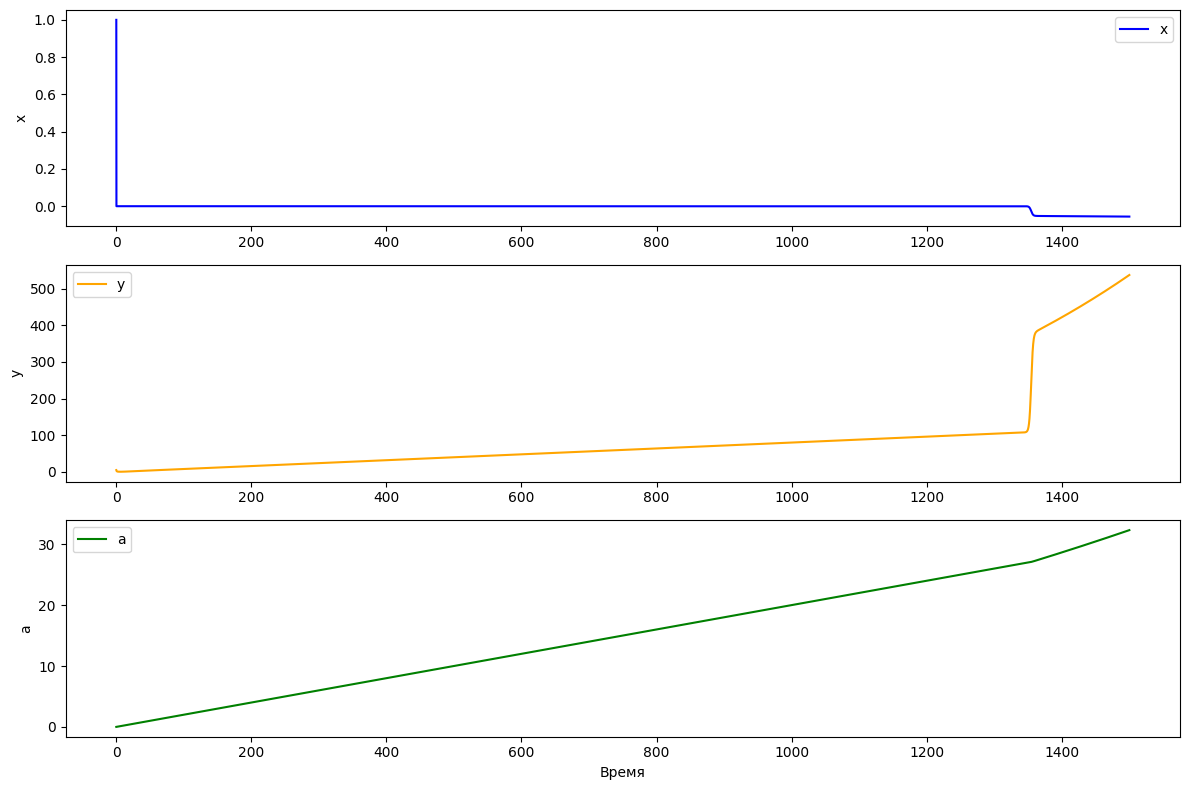

In [4]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Параметры системы (τ добавлен как параметр)
epsilon = 0.01
tau = 1.0  # Пример значения, должно быть задано в задаче!

# Функции правых частей с исправленными формулами
def f_x(x, y, a):
    return x * (1 - 0.5*x - (2/(tau * a**2)) * y)  # Исправлена ошибка в скобках

def f_y(x, y, a):
    return y * (2*a - 3.5*a**2*x - 0.5*y)

def f_a(x, a):
    return epsilon * (2 - tau*a*x)

def system_rhs(t, state):
    x, y, a = state
    dxdt = f_x(x, y, a)
    dydt = f_y(x, y, a)
    dadt = f_a(x, a)  # Исправлено: y не используется в уравнении для a
    return np.array([dxdt, dydt, dadt])

# Неявный метод Рунге-Кутты 3-го порядка (Radau IIA)
def implicit_rk3_step(t, state, h):
    # Коэффициенты метода Radau IIA 3-го порядка
    A = np.array([
        [5/24, 1/3, -1/24],
        [1/6, 2/3, 1/6],
        [1/6, 2/3, 1/6]
    ])
    b = np.array([1/6, 2/3, 1/6])
    c = np.array([1/2, 1, 1])

    def equations(k):
        k1, k2, k3 = k[0:3], k[3:6], k[6:9]
        stages = [
            state + h * (A[0,0]*k1 + A[0,1]*k2 + A[0,2]*k3),
            state + h * (A[1,0]*k1 + A[1,1]*k2 + A[1,2]*k3),
            state + h * (A[2,0]*k1 + A[2,1]*k2 + A[2,2]*k3)
        ]
        residuals = np.concatenate([
            k1 - system_rhs(t + c[0]*h, stages[0]),
            k2 - system_rhs(t + c[1]*h, stages[1]),
            k3 - system_rhs(t + c[2]*h, stages[2])
        ])
        return residuals

    # Начальное приближение
    k_guess = np.concatenate([system_rhs(t, state)]*3)

    # Решение нелинейной системы
    k_solution = fsolve(equations, k_guess, xtol=1e-6)

    # Обновление состояния
    new_state = state + h * (b[0]*k_solution[0:3] + b[1]*k_solution[3:6] + b[2]*k_solution[6:9])
    return new_state

# Решение системы с адаптивным шагом
def solve_system(x0, y0, a0, Tk, h=0.1):
    t = 0.0
    state = np.array([x0, y0, a0], dtype=np.float64)
    times = [t]
    states = [state.copy()]

    while t < Tk:
        state = implicit_rk3_step(t, state, h)
        t += h
        times.append(t)
        states.append(state.copy())

        # Адаптация шага при необходимости
        if np.any(np.abs(state) > 1e6):  # Проверка на взрыв
            raise RuntimeError("Решение расходится!")

    return np.array(times), np.array(states)

# Начальные условия (должны быть << 1 для a0)
x0 = 1.0
y0 = 5.0
a0 = 0.001  # Должно быть мало согласно условию 0 < a0 ≪ 1

# Решение с меньшим шагом
times, states = solve_system(x0, y0, a0, 1500, h=0.1)

# Визуализация
plt.figure(figsize=(12, 8))
for i, (label, color) in enumerate(zip(['x', 'y', 'a'], ['blue', 'orange', 'green'])):
    plt.subplot(3, 1, i+1)
    plt.plot(times, states[:, i], color=color, label=label)
    plt.ylabel(label)
    plt.legend()
plt.xlabel('Время')
plt.tight_layout()
plt.show()

In [5]:
# Create sliders
x_slider = widgets.FloatSlider(
    value=2,  # Initial value
    min=0,     # Minimum value
    max=3,   # Maximum value
    step=0.001,    # Step size
    description='X:'
)

y_slider = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=15.0,
    step=0.001,
    description='Y:'
)

a_slider = widgets.FloatSlider(
    value=0.1,
    min=0.0,
    max=1.0,
    step=0.001,
    description='Z Range:'
)

e_slider = widgets.FloatSlider(
    value=0.001,
    min=0.0,
    max=0.01,
    step=0.001,
    description='Z Range:'
)

# Display the sliders
display(x_slider, y_slider, a_slider, e_slider)

FloatSlider(value=2.0, description='X:', max=3.0, step=0.001)

FloatSlider(value=0.5, description='Y:', max=15.0, step=0.001)

FloatSlider(value=0.1, description='Z Range:', max=1.0, step=0.001)

FloatSlider(value=0.001, description='Z Range:', max=0.01, step=0.001)

In [8]:
x_n = x_slider.value
y_n = y_slider.value
a_n = a_slider.value
eps = e_slider.value

_1, _2, _3 = runge_kutta_4(x_n, y_n, a_n, h)

plot(_1, _2)
plot(_1, _3)


<IPython.core.display.Javascript object>

KeyboardInterrupt: 